### ODE from Navier Stokes Data

In [1]:
%pylab inline

import numpy as np
import tensorflow as tf
from scipy.integrate import odeint
from utils import *
import scipy.io as sio

np.random.seed(0)

#
#
noise_percent = 0
#
#

Populating the interactive namespace from numpy and matplotlib


### Generate data

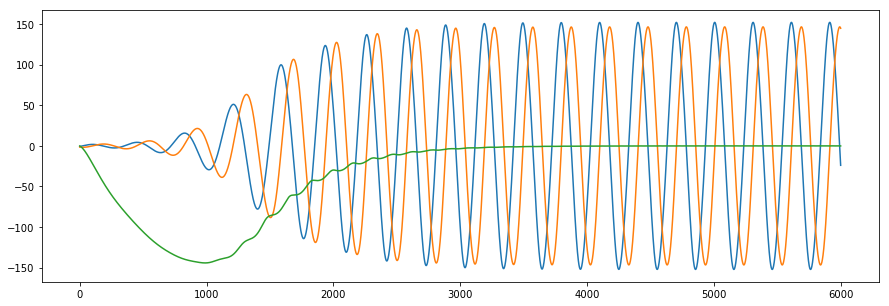

In [2]:
# Load data from Navier stokes simulation
data = sio.loadmat('PODcoefficients_run1.mat')
X = np.hstack([data['alpha'][:,:2], data['alphaS']]).T

n,m = X.shape
dt = 0.02

figure(figsize = (15,5))
plot(X[0,:])
plot(X[1,:])
plot(X[2,:])

In [3]:
n = X.shape[0]
noise_level = [0.01*noise_percent*np.std(X[j,:]) for j in range(n)]
measurement_noise = np.vstack([noise_level[j]*np.random.randn(m) for j in range(n)])

Y = X + measurement_noise

In [4]:
N_hat, X_hat = approximate_noise(Y, lam = 1)

### Train 

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

net_params = get_network_variables(n, 3, 64, N_hat)
optimizer, placeholders = create_computational_graph(n, N_hat, net_params)

init = tf.global_variables_initializer()
sess.run(init)

In [6]:
if True: 
    saver = tf.train.Saver()
    saver.restore(sess, "./saved_sessions/NS_0.ckpt")
    
else:
    num_dt = 10

    feed_dict = {placeholders['Y_0']: Y[:,num_dt:m-num_dt], 
                 placeholders['T_0']: (np.arange(m-2*num_dt)*dt).reshape(1,m-2*num_dt),
                 placeholders['h']: np.array([[dt]])}

    for j in range(num_dt):
        feed_dict[placeholders['true_forward_Y'][j]] = Y[:,num_dt+j+1:m-num_dt+j+1]
        feed_dict[placeholders['true_backward_Y'][j]] = Y[:,num_dt-j-1:m-num_dt-j-1]

    optimizer.minimize(sess, feed_dict=feed_dict)

INFO:tensorflow:Restoring parameters from ./saved_sessions/NS_0.ckpt


In [7]:
X_test = np.zeros((3,5*m))
X_test[:,0] = X[:,0]

weights, biases, N = net_params

x_next_test = RK4_forward(placeholders['Y_0'], placeholders['T_0'], simple_net, placeholders['h'], weights, biases)

for j in range(5*m-1):
    X_test[:,j+1] = sess.run(x_next_test, feed_dict={placeholders['Y_0']: np.array([X_test[:,j]]).T, 
                                                    placeholders['T_0']: np.array([[j*dt]]), 
                                                    placeholders['h']: np.array([[dt]])}).flatten()

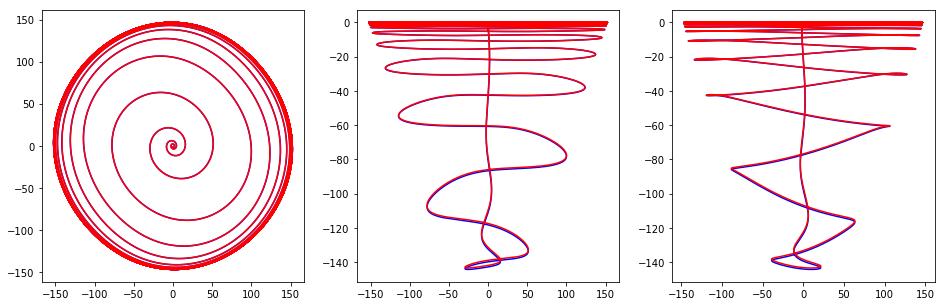

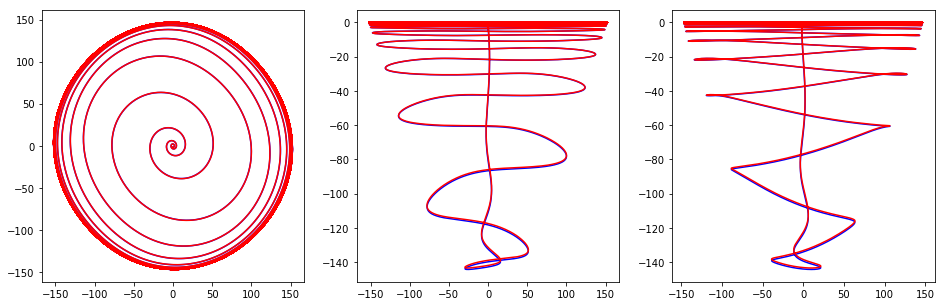

In [8]:
figure(figsize=(16,5))
subplot(1,3,1); plot(X[0,:m],X[1,:m],'b'); plot(X_test[0,:m],X_test[1,:m],'r')
subplot(1,3,2); plot(X[0,:m],X[2,:m],'b'); plot(X_test[0,:m],X_test[2,:m],'r')
subplot(1,3,3); plot(X[1,:m],X[2,:m],'b'); plot(X_test[1,:m],X_test[2,:m],'r')

figure(figsize=(16,5))
subplot(1,3,1); plot(X[0,:m],X[1,:m],'b'); plot(X_test[0,:],X_test[1,:],'r')
subplot(1,3,2); plot(X[0,:m],X[2,:m],'b'); plot(X_test[0,:],X_test[2,:],'r')
subplot(1,3,3); plot(X[1,:m],X[2,:m],'b'); plot(X_test[1,:],X_test[2,:],'r')

In [9]:
if False: 
    saver = tf.train.Saver()
    saver.save(sess, "./saved_sessions/NS_0.ckpt")

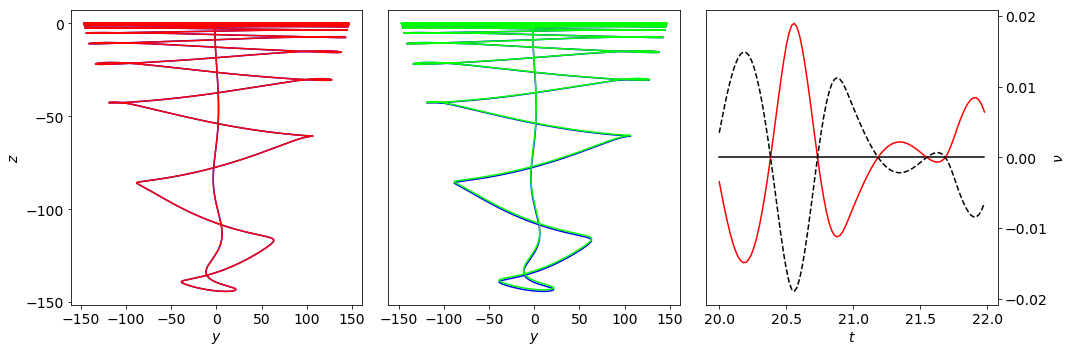

In [10]:
figure(figsize = (15,5))

subplot(1,3,1)
plot(Y[1,:], Y[2,:], 'b')
plot((Y-N.eval())[1,:], (Y-N.eval())[2,:], 'r')
xticks([-150,-100,-50,0,50,100,150], fontsize = 14)
yticks([-150,-100,-50,0], fontsize = 14)
ylabel(r'$z$', fontsize = 14)
xlabel(r'$y$', fontsize = 14)

subplot(1,3,2)
plot(X[1,:], X[2,:], 'b')
plot(X_test[1,:], X_test[2,:], color = (0,1,0))
yticks([])
xticks([-150,-100,-50,0,50,100,150], fontsize = 14)
xlabel(r'$y$', fontsize = 14)

ax = subplot(1,3,3)

start = 1000
end = 1100

plot(dt*np.arange(start,end), N.eval()[0,start:end], 'r')
plot(dt*np.arange(start,end), (measurement_noise-N.eval())[0,start:end], 'k--')
plot(dt*np.arange(start,end), np.zeros(end-start), 'k', zorder = 0)
xticks([20,20.5,21,21.5,22], fontsize = 14)
xlabel(r'$t$', fontsize = 14)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ylabel(r'$\nu$', fontsize = 14)
yticks([-0.02,-0.01,0,0.01,0.02], fontsize = 14)

tight_layout()

In [11]:
NS_1_data = np.load("./saved_sessions/NS_1_data.npy").item()

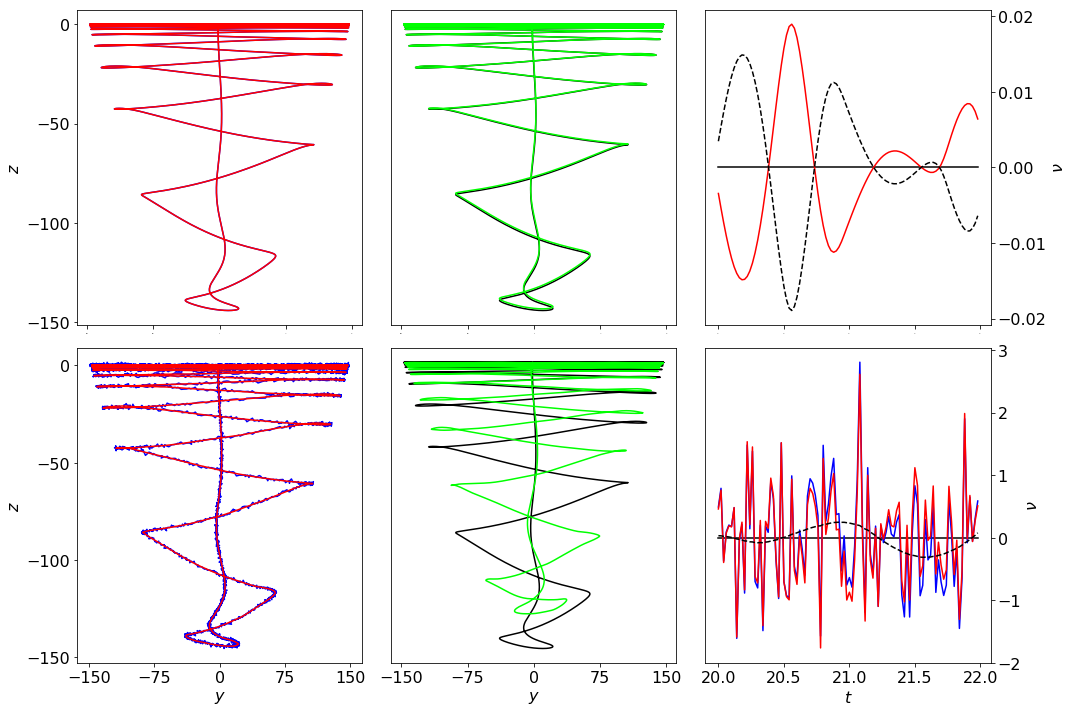

In [12]:
figure(figsize = (15,10))
fs = 16

subplot(2,3,1)
plot(Y[1,:], Y[2,:], 'b')
plot((Y-N.eval())[1,:], (Y-N.eval())[2,:], 'r')
xticks([-150,-75,0,75,150], fontsize = 0)
yticks([-150,-100,-50,0], fontsize = fs)
ylabel(r'$z$', fontsize = fs)
# xlabel(r'$y$', fontsize = 14)

subplot(2,3,2)
plot(X[1,:], X[2,:], 'k')
plot(X_test[1,:], X_test[2,:], color = (0,1,0))
yticks([])
xticks([-150,-75,0,75,150], fontsize = 0)
# xlabel(r'$y$', fontsize = 14)

ax = subplot(2,3,3)

start = 1000
end = 1100

plot(dt*np.arange(start,end), N.eval()[0,start:end], 'r')
plot(dt*np.arange(start,end), (measurement_noise-N.eval())[0,start:end], 'k--')
plot(dt*np.arange(start,end), np.zeros(end-start), 'k', zorder = 0)
xticks([20,20.5,21,21.5,22], fontsize = 0)
# xlabel(r'$t$', fontsize = 14)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ylabel(r'$\nu$', fontsize = fs)
yticks([-0.02,-0.01,0,0.01,0.02], fontsize = fs)

###############################################################################

subplot(2,3,4)
plot(NS_1_data['Y'][1,:], NS_1_data['Y'][2,:], 'b')
plot((NS_1_data['Y']-NS_1_data['N_hat'])[1,:], (NS_1_data['Y']-NS_1_data['N_hat'])[2,:], 'r')
xticks([-150,-75,0,75,150], fontsize = fs)
yticks([-150,-100,-50,0], fontsize = fs)
ylabel(r'$z$', fontsize = fs)
xlabel(r'$y$', fontsize = fs)

subplot(2,3,5)
plot(X[1,:], X[2,:], 'k')
plot(NS_1_data['X_test'][1,:], NS_1_data['X_test'][2,:], color = (0,1,0))
yticks([])
xticks([-150,-75,0,75,150], fontsize = fs)
xlabel(r'$y$', fontsize = fs)

ax = subplot(2,3,6)

start = 1000
end = 1100

plot(dt*np.arange(start,end), NS_1_data['N'][0,start:end], 'b')
plot(dt*np.arange(start,end), NS_1_data['N_hat'][0,start:end], 'r')
plot(dt*np.arange(start,end), (NS_1_data['N']-NS_1_data['N_hat'])[0,start:end], 'k--')
plot(dt*np.arange(start,end), np.zeros(end-start), 'k', zorder = 0)
xticks([20,20.5,21,21.5,22], fontsize = fs)
xlabel(r'$t$', fontsize = fs)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ylabel(r'$\nu$', fontsize = fs)
yticks([-2,-1,0,1,2,3], fontsize = fs)

tight_layout()

In [13]:
noise_error = np.linalg.norm(measurement_noise - N.eval(),'fro')**2 / m
print(noise_error)

0.000101946476523
